Stratégie de cross validation : Il est important que la cross validation soit bien ficelée
- 1/ sort_value ascending=true sur timestamp
- 2/ Découpage en 5 morceaux
- 3/ Premier CV sur les 2 premiers morceaux dans le temps
- 4/ Second CV sur les 3 premiers morceaux dans le temps
- 5/ Ainsi de suite jusqu'à la fin.

In [1]:
import numpy as np
import pandas as pd

from functions import *

In [2]:
%%time

path = "C:/riiid-test-answer-prediction/reduced_riiid_train.pkl.gzip"
train = pd.read_pickle(path)
train = train.astype({'row_id': 'int64',
                      'timestamp': 'int64',
                      'user_id': 'int32',
                      'content_id': 'int16',
                      'content_type_id': 'int8',
                      'task_container_id': 'int16',
                      'user_answer': 'int8',
                      'answered_correctly': 'int8',
                      'prior_question_elapsed_time': 'float32',
                      'prior_question_had_explanation': 'boolean'})
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37408927 entries, 0 to 37408926
Data columns (total 12 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   row_id                          int64  
 1   timestamp                       int64  
 2   user_id                         int32  
 3   content_id                      int16  
 4   content_type_id                 int8   
 5   task_container_id               int16  
 6   user_answer                     int8   
 7   answered_correctly              int8   
 8   prior_question_elapsed_time     float32
 9   prior_question_had_explanation  boolean
 10  question_id                     int64  
 11  part                            int64  
dtypes: boolean(1), float32(1), int16(2), int32(1), int64(4), int8(3)
memory usage: 2.0 GB
Wall time: 4.39 s


In [3]:
train = train.sort_values(by='timestamp')
train

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,question_id,part
0,0,0,115,5692,0,1,3,1,NaN,<NA>,5692,5
37122560,54696112,0,1159748152,8218,0,0,1,0,NaN,<NA>,8218,5
37122562,55106913,0,1168991778,8218,0,0,3,0,NaN,<NA>,8218,5
12137367,95952189,0,2034938405,8215,0,0,1,0,NaN,<NA>,8215,5
12137359,94550773,0,2007089960,8215,0,0,0,1,NaN,<NA>,8215,5
...,...,...,...,...,...,...,...,...,...,...,...,...
4335288,75110613,28684362990,1598791376,7685,0,20,2,0,24000.0,True,7685,7
4343070,75110612,28684362990,1598791376,7688,0,20,3,0,24000.0,True,7688,7
4339179,75110610,28684362990,1598791376,7686,0,20,3,0,24000.0,True,7686,7
16371664,78859776,28684765728,1678328767,393,0,70,0,1,3000.0,True,393,2


In [7]:
#train[train.user_id == 1159748152]

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,question_id,part
37122560,54696112,0,1159748152,8218,0,0,1,0,NaN,<NA>,8218,5
27689071,54696113,33908,1159748152,5772,0,1,3,1,18000.0,False,5772,5
36127188,54696114,50575,1159748152,11381,0,2,1,1,28000.0,False,11381,5
35860247,54696115,78661,1159748152,9418,0,3,0,0,13000.0,False,9418,5
36589409,54696116,104097,1159748152,4920,0,4,1,0,23000.0,False,4920,5
19800160,54696117,138458,1159748152,6033,0,5,0,0,21000.0,False,6033,5
14412640,54696118,168152,1159748152,4005,0,6,3,1,28000.0,False,4005,5
25747069,54696119,2695720,1159748152,9234,0,7,0,1,25000.0,False,9234,5
10789576,54696120,2755384,1159748152,9449,0,8,1,0,21000.0,True,9449,5
8802419,54696121,2847253,1159748152,3643,0,9,0,0,17000.0,True,3643,5


In [8]:
#train[train.content_id == 8218]

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,question_id,part
37122560,54696112,0,1159748152,8218,0,0,1,0,NaN,<NA>,8218,5
37122562,55106913,0,1168991778,8218,0,0,3,0,NaN,<NA>,8218,5
37122573,58608075,0,1243391344,8218,0,0,2,1,NaN,<NA>,8218,5
37122550,52315635,0,1109443622,8218,0,0,2,1,NaN,<NA>,8218,5
37122595,62928829,0,1338018274,8218,0,0,3,0,NaN,<NA>,8218,5
...,...,...,...,...,...,...,...,...,...,...,...,...
37122656,80692440,19385876186,1716706419,8218,0,843,2,1,14000.0,True,8218,5
37122537,47858369,20672447612,1011708129,8218,0,696,2,1,11000.0,True,8218,5
37122431,11299576,20938806155,245053228,8218,0,1077,2,1,11000.0,True,8218,5
37122475,24958387,21505502554,533811449,8218,0,55,2,1,19000.0,True,8218,5


In [4]:

## En prévision de remplacer les NaN par les moyennes des questions.

# %%time
# agg = {'row_id' : 'count',
#        'part': 'max',
#        'prior_question_elapsed_time' : lambda x: round(x.mean()),
#        'prior_question_had_explanation' : lambda x: True if x.mean() > 0.5 else False,
#        'answered_correctly' : lambda x: round(x.mean() * 100)}

# content_info = train.groupby('content_id').agg(agg)
# content_info = content_info.rename(columns={'row_id' : 'nb_interactions',
#                                             'prior_question_elapsed_time' : 'mean_prior_question_elapsed_time',
#                                             'prior_question_had_explanation' : 'most_used_prior_question_had_explanation'})
# content_info

Wall time: 12.1 s


,nb_interactions,part,mean_prior_question_elapsed_time,most_used_prior_question_had_explanation,answered_correctly
content_id,,,,,
0,2841,1,22377.0,True,91
1,2892,1,22367.0,True,86
2,24875,1,23636.0,True,54
3,11290,1,23457.0,True,77
4,15352,1,23290.0,False,60
...,...,...,...,...,...
13518,446,5,25791.0,True,74
13519,461,5,27257.0,True,53
13520,436,5,23548.0,True,65


In [5]:
train.isna().sum()

row_id                                 0
timestamp                              0
user_id                                0
content_id                             0
content_type_id                        0
task_container_id                      0
user_answer                            0
answered_correctly                     0
prior_question_elapsed_time       192370
prior_question_had_explanation    192370
question_id                            0
part                                   0
dtype: int64

In [19]:
train = train.dropna().reset_index(drop=True)
train

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,question_id,part
0,45696409,0,967672499,7636,0,0,0,1,48666.0,True,7636,7
1,45696408,0,967672499,7635,0,0,2,1,48666.0,True,7635,7
2,45696407,0,967672499,7637,0,0,2,0,48666.0,True,7637,7
3,6899015,0,150202195,10072,0,0,0,1,25000.0,True,10072,6
4,6899016,0,150202195,10070,0,0,0,1,25000.0,True,10070,6
...,...,...,...,...,...,...,...,...,...,...,...,...
37216552,75110613,28684362990,1598791376,7685,0,20,2,0,24000.0,True,7685,7
37216553,75110612,28684362990,1598791376,7688,0,20,3,0,24000.0,True,7688,7
37216554,75110610,28684362990,1598791376,7686,0,20,3,0,24000.0,True,7686,7
37216555,78859776,28684765728,1678328767,393,0,70,0,1,3000.0,True,393,2


In [13]:
feat = ['timestamp', 'user_id', 'content_id', 'task_container_id',
        'prior_question_elapsed_time', 'prior_question_had_explanation', 'part']
target = 'answered_correctly'

X = train[feat]
y = train[target]

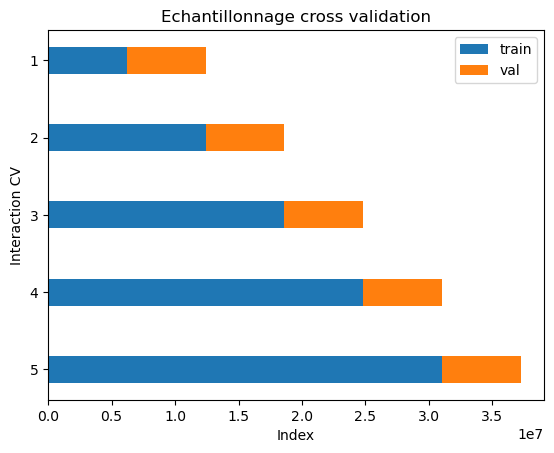

In [95]:
from sklearn.model_selection import TimeSeriesSplit
# Initialisation du TSCV
n_iter = 5
tscv = TimeSeriesSplit(n_splits=n_iter)

# Echantillonnage
train_lst = []
val_lst = []

for train_index, val_index in tscv.split(X):
    train_lst.append(train_index[-1])
    val_lst.append(val_index[-1] - val_index[0])
    
    # X_train, X_test = X.iloc[train_index], X.iloc[val_index]
    # y_train, y_test = y.iloc[train_index], y.iloc[val_index]

train_tpl = tuple(train_lst)
val_tpl = tuple(val_lst)

# Tracage de l'échantillon
ind = np.arange(n_iter) + 1
width = 0.35

btrain = plt.barh(ind, train_tpl, width)
bval = plt.barh(ind, val_tpl, width, left=train_tpl)

plt.yticks(ind)
plt.gca().invert_yaxis()
plt.legend((btrain, bval), ("train", "val"))
plt.title('Echantillonnage cross validation')
plt.ylabel('Interaction CV')
plt.xlabel('Index')

plt.show()

In [73]:
ind

array([0, 1, 2])